In [1]:
import IPython
import pandas as pd
from scipy.io import wavfile

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import numpy as np
import math

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dropout,Dense, BatchNormalization, GRU
from tensorflow.keras import activations
from tensorflow.keras import regularizers
from pickle import load

from helper import to_sequences, to_sequences_new, predict_song

## Data Loading and Preprocessing

In [2]:
#load file

#set your music file path
directory = '../../data/wav_csvs/downsample'
x_files = []
count=0
for filename in os.listdir(directory):
    print(filename)
    if count ==3: #only load 4 wav files 
        break
    if('xData' in filename):
        x_files.append(pd.read_csv(directory + '/' + filename, index_col=0))
        count=count+1
#concatenate into a long sequence
x_combined = pd.concat(x_files)

.DS_Store
xData0-50-10.csv
xData1-50-10.csv
xData10-50-10.csv
xData11-50-10.csv


In [3]:
max_val = np.max(np.abs(np.array(x_combined.values).flatten()))
print ("max_val", max_val)
x_combined /= max_val
x_combined

max_val 32768


,0,1,2,3,4,5,6,7,8,9,...,44090,44091,44092,44093,44094,44095,44096,44097,44098,44099
1.wav-1,-0.001404,-0.058075,-0.061829,-0.033051,-0.004181,-0.011353,-0.013519,0.009613,0.067688,0.145020,...,0.110443,0.092407,0.066772,0.024506,-0.087036,-0.127167,-0.083252,0.001526,0.033020,0.035828
1.wav-2,-0.081665,-0.069031,0.015869,0.091827,0.130890,0.106232,0.050079,0.024109,0.042297,0.056061,...,0.223389,0.184326,0.134094,0.079468,0.038483,0.033020,0.011230,0.000763,-0.027130,-0.050720
10.wav-1,-0.160278,-0.198425,-0.173370,-0.148346,-0.108002,-0.078461,-0.054565,-0.043823,-0.029572,0.017822,...,-0.260712,-0.235382,-0.240417,-0.211792,-0.178619,-0.152222,-0.131256,-0.077606,-0.021179,-0.002472
10.wav-2,-0.122742,-0.209473,-0.229523,-0.187653,-0.168945,-0.188202,-0.195435,-0.242188,-0.280273,-0.279938,...,0.469910,0.298737,0.162201,0.101501,0.109802,0.108948,-0.002197,-0.196960,-0.416443,-0.549744
100.wav-1,0.003906,-0.182983,-0.348877,-0.452881,-0.509644,-0.411987,-0.265991,-0.072968,0.071198,0.111206,...,-0.137512,-0.132751,-0.052704,0.009857,0.102692,0.153290,0.167877,0.126556,0.095093,0.029449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533.wav-2,-0.701324,-0.744751,-0.761200,-0.749786,-0.720520,-0.664490,-0.575714,-0.465027,-0.362854,-0.220734,...,0.006409,0.068146,0.166718,0.242249,0.254700,0.252655,0.209808,0.198090,0.133972,0.089752
535.wav-1,-0.166412,-0.238831,-0.287537,-0.211731,-0.105560,-0.096527,-0.123627,-0.185425,-0.176422,-0.211945,...,0.044708,0.023346,0.037109,-0.002777,0.024902,0.030579,0.016205,0.009644,0.017151,0.013153
535.wav-2,0.207428,0.464783,0.529114,0.311188,0.061584,-0.140900,-0.028351,0.086975,0.319153,0.413727,...,-0.010406,0.091736,0.122620,0.140747,0.074463,0.033905,-0.014282,-0.124939,-0.143036,-0.129272
536.wav-1,0.324890,0.391357,0.309662,0.165131,0.052399,0.030304,-0.024414,-0.118500,-0.134308,-0.192383,...,0.115601,0.083710,0.202728,0.327850,0.255005,0.047241,-0.154510,-0.250366,-0.125153,0.050232


In [17]:
input_len = 1000
output_len = 100

x_sequences = []
y_sequences = []
for x in range(20):
    temp_x, temp_y = to_sequences_new(np.array(x_combined.iloc[x]), input_len = input_len, output_len = output_len, stride = 100)
    x_sequences.append(temp_x)
    y_sequences.append(temp_y)
    
X = np.concatenate(x_sequences, axis = 0)
y = np.concatenate(y_sequences, axis = 0)
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.10, random_state=42)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [8]:
loaded_model = keras.models.load_model('models/model3')

In [12]:
trainX[0].shape

(1000, 1)

In [18]:
xPred0 = predict_song(loaded_model, 32768, trainX[1], 10, include_x = True, input_size = 1000, output_size = 100)

In [19]:
samplerate= 44100 // 10
IPython.display.Audio(xPred0.astype(int), rate=samplerate)

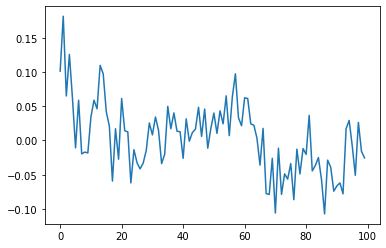

In [24]:
plt.plot(loaded_model.predict(np.array([trainX[1]]))[0])

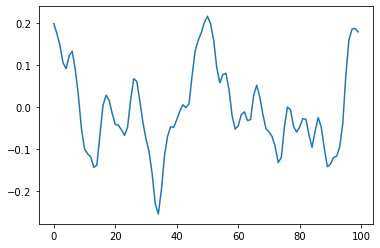

In [25]:
plt.plot(trainY[1])

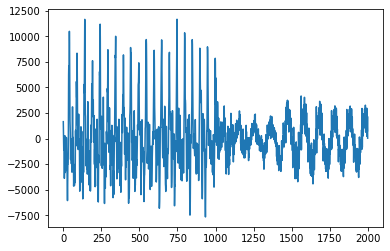

In [21]:
plt.plot(xPred0[0:5000])

In [17]:
wavfile.write("model2-output.wav", samplerate, xPred0.astype(np.int16))

In [56]:
xPred0.astype(int)

array([  -46, -1903, -2026, ...,  -310,   227,   307])